---
# POC Synthetische data & Gemeente Amsterdam

---
**Achtergrond**
> De gemeente Amsterdam verzameld een groot aantal gegevens van hun burgers om de verschillende wettelijke taken uit te voeren. Deze taken richten zich onder andere op het zorgdomein (e.g., WMO, Jeugdzorg, publieke gezondheid zoals deze door de GGD wordt uitgevoerd). Doordat er verschillende zorgwetten zijn is het niet triviaal vanuit de privacy richtlijnen om persoonsgegevens vanuit verschillende zorgdomeinen binnen een persoon aan elkaar te koppelen. Hoewel er wel mogelijkheden zijn om dit te doen (e.g., microdata omgeving CBS, zicht en grip pilot vanuit de gemeente Amsterdam) zijn deze vaak omslachtig en duur.
>
> Een andere uitdaging met het werken van persoonsgegevens is dat deze, zelfs binnen een enkele wet, niet zo maar gedeeld kunnen worden met andere interne of externe onderzoekers. Om dit mogelijk te maken zal er eerst (minimaal) een Data Protection Impact Assessment (DPIA) uitgevoerd moeten worden die gevolgd wordt door een Data Sharing Agreement (DSA). Dit process is op het moment van schrijven niet optimaal waardoor projecten langzaam van start kunnen gaan en andere kleine vraagstukken überhaupt niet opgepakt worden omdat het niet de tijdsinvestering van de DPIA niet waard is.

**Een alternatief**
> Vanuit de AI en data science domeinen zijn er methodes ontwikkeld die een gebruiker instaat stelt om aan de hand van persoonsgegevens _synthetische data_ te creëren. Deze _synthetische data_ bevat alle statistische kenmerken van de waargenomen persoonsgegevens, maar elk nieuw datapunt is dus niet gebaseerd op een individu. Een van de voordelen van _synthetische data_ is dat het een aantal privacy processen mogelijk overbodig maakt waardoor het makkelijk wordt om data te combineren over wetten en te delen met interne en externe onderzoekers.

**Doel van dit notebook**
> Het doel van deze proof of concept (POC) notebook is om aan de hand van een veelgebruikt publiekelijke dataset het concept van _synthetische data_ en een aantal kwaliteitscontroles te introduceren. Om daarna het gesprek met de privacy officier te kunnen voeren of:
1) synthetische data veelbelovend is voor de gemeente Amsterdam
2) aan welke kwaliteitseisen deze synthetische data moet voldoen voordat deze vrij gedeeld zou kunnen worden


**Auteur notebook**
> Loek Berkers (l.berkers@amsterdam.nl)  
> Max Keuken (mkeuken@ggd.amsterdam.nl)

---


---
## Adult data importeren en beschrijven

---
> Adult data van de VS afkomstig uit de UCI Machine Learning repository, opgeschoond en standaard opgekomen in het python package SDV (Synthetic Data Vault) wat in dit notebook wordt gebruikt om synthetische data te genereren. De census data bevat een enkele tabel op persoonsniveau met 15 verschillende eigenschappen van elk individu. Zie hieronder voor een interactief overzicht van de data.

In [7]:
from sdv.demo import load_tabular_demo
metadata, data = load_tabular_demo("adult", metadata=True)

import sweetviz as sv
import warnings
warnings.filterwarnings("ignore")
my_report = sv.analyze(data)
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


---
## Model selectie

---
Binnen SDV zijn er een groot aantal verschillende modellen die gebruikt kunnen worden om synthetische data van een tabel te genereren. Drie populaire modellen binnen SDV die gebruikt worden voor single tabel synthetische data generatie zijn:
1) FASTMLPreset
2) GuassianCopulateSynthesizer
3) CTGANSynthesizer

We kunnen alle drie de modellen toepassen op de data waarbij we willen weten welk model het beste presteert. Binnen SDV heb je hiervoor een functie 'sdgym' die verschillende modellen achter elkaar runt en samenvat.

In [1]:
import sdgym
warnings.filterwarnings("ignore")

sdgym.benchmark_single_table(
    sdv_datasets=["adult"],
)

,Synthesizer,Dataset,Dataset_Size_MB,Train_Time,Peak_Memory_MB,Synthesizer_Size_MB,Sample_Time,Evaluate_Time,Quality_Score,NewRowSynthesis
0,GaussianCopulaSynthesizer,adult,3.907448,1.762503,44.903259,0.151074,1.048487,12.761993,0.830362,1.0
1,FastMLPreset,adult,3.907448,0.929069,44.551225,0.157097,0.923271,12.795663,0.823166,1.0
2,CTGANSynthesizer,adult,3.907448,1256.416546,150.656568,44.590868,1.887774,10.934996,0.894680,1.0


Hoewel de CTGANSythesizer veruit het langszaamst is (factor 1000!) en 3x zo veel geheugen gebruikt is de kwaliteit van de uitkomst 7.7% beter dan de GaussianCopulaSYnthesizer en 8.7% beter dan FastMLPreset met soortgelijke score op NewRowSynthesis.

**Definitie van Quality_Score:**
> De gemiddelde kwaliteitsscore van alle geincludeerde kolommen. De afzonderlijke kwaliteitsscore voor de continue kolommen worden berekend door middel van de Kolmogorov-Smirnov (KS) statistiek. Deze maat wordt berekend door de numerieke distributie om te zetten naar de cumulatieve distributie functie (CDF). De KS statistiek is het maximale verschil tussen de CDF van de echte data en de CDF van de synthetische data. Als deze 1.0 is dan is er geen verschil tussen de twee CDFs en is er sprake van hoge kwaliteit synthetische data. De kwaliteitsscore voor categorische kolommen worden berekend door middel van de total variation distance (TVD). Deze maat wordt berekend door eerst de frequentie van elke category waarde te bepalen en deze te vertalen naar een probabiliteit. De TVD statistiek vergelijkt de probabiliteitsverschillen per categoriewaarde tussen de echte en synthetische data. Als deze 1.0 is dan is er geen verschill tussen de twee TVDs en is er sprake van hoge kwaliteit.

 **Definitie van NewRowSynthesis:**
 > Deze maat geeft aan hoeveel van de synthetische data een identieke kopie is van de orginele data. Als deze waarde 0.0 is dan betekend dit dat alle synthetische data punten terug te vinden zijn in de orginele data. Als deze waarde 1.0 is dan betekend dit dat er geen enkel synthetisch datapunt overeenkomt met een echt data punt.

---
## CTGAN

---

Het CTGAN model geimplementeerd in SDV is gebaseerd op het generative adversarial neural (GAN) deep learning data synthesizer zoals deze gepresenteerd is in het manuscript "Modeling Tabular data using Conditional GAN" (NeurIPS, 2020). Het voordeel van een GAN model is dat het inherent differential privacy eigenschappen heeft en bescherming tegen membership attacks (Lin et al. 2022). Waarbij de differential privacy hoger is als je meer training samples hebt om het model te trainen maar ook afneemt als je meer synthetische data gaat genereren met een getraind model.

Er zijn 4 hoofdklasse van privacy aanvallen die direct relevant zijn voor GANs:
1) **Re-identification attacks** Door middel van externe databronnen of achtergrond kennis kan het mogelijk zijn om de volledige gegevens van een individu in de trainingsdata te achterhalen.
2) **Attribute inference attack** Als je compenseert voor re-identification attacks door gebruik te maken van bijvoorbeeld k-membership methodes is het nog steeds mogelijk om aan de hand van externe databronnen specifieke attributen van een groep individueen in de trainingsdata te bepalen.
3) **Membership inference attack** Als iemand toegang heeft tot het getrainde model en de code waarmee het model is getraind (black box access) is het mogelijk om eigenschappen van de trainingsdata te leren door naar het gedrag van het model te kijken in relatie tot de output.
4) **Memorization of sensitive training samples** Het model is verkeerd getraind met als gevolg dat het model de daadwerkelijke trainingsdata heeft onthouden en dat gebruikt om synthetische data te genereren. Als iemand toegang heeft tot het daadwerkelijke model dan is het redelijk simpel om de originele trainingsdata te genereren.

Een deel van de privacy concerns kunnen worden gekwantificeerd met de metric van NewRowSynthesis, daarnaast is dit nog steeds een actief onderzoeksveld en worden er nieuwe methodes voorgesteld om bovenstaande privacy attacks te mitigeren (zie e.g., Kuppta et al. 2021 & Borji 2021 voor een overzicht van methodes).


### Model definitie en model fitten

In [1]:
from sdv.demo import load_tabular_demo
metadata, data = load_tabular_demo("adult", metadata=True)

from sdv.tabular import CTGAN
model_ctgan = CTGAN(
    table_metadata=metadata,
    cuda=False,
)
model_ctgan.fit(data)

### Synthetische data creeren

In [2]:
synth_data_ctgan = model_ctgan.sample(num_rows=1000)

### Diagnostic and Quality reports
    SDV has two standard reports that you can create to determine how well the model
    was able to generate synthetic data. Beyond these standard summary reports you can
    generate a number of different visuals that will help evaluate the results in more
    detail.

In [14]:
synth_data_ctgan = model_ctgan.sample(num_rows=1000)

Creating report: 100%|██████████| 4/4 [00:15<00:00,  3.76s/it]
/Users/mckitchen/Documents/GitHub/gan/venv/lib/python3.9/site-packages/sdmetrics/reports/single_table/diagnostic_report.py:211: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.




DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the categories present in the real data

DANGER:
x More than 50% of the synthetic rows are copies of the real data


Creating report: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Overall Quality Score: 87.08%

Properties:
Column Shapes: 89.79%
Column Pair Trends: 84.37%


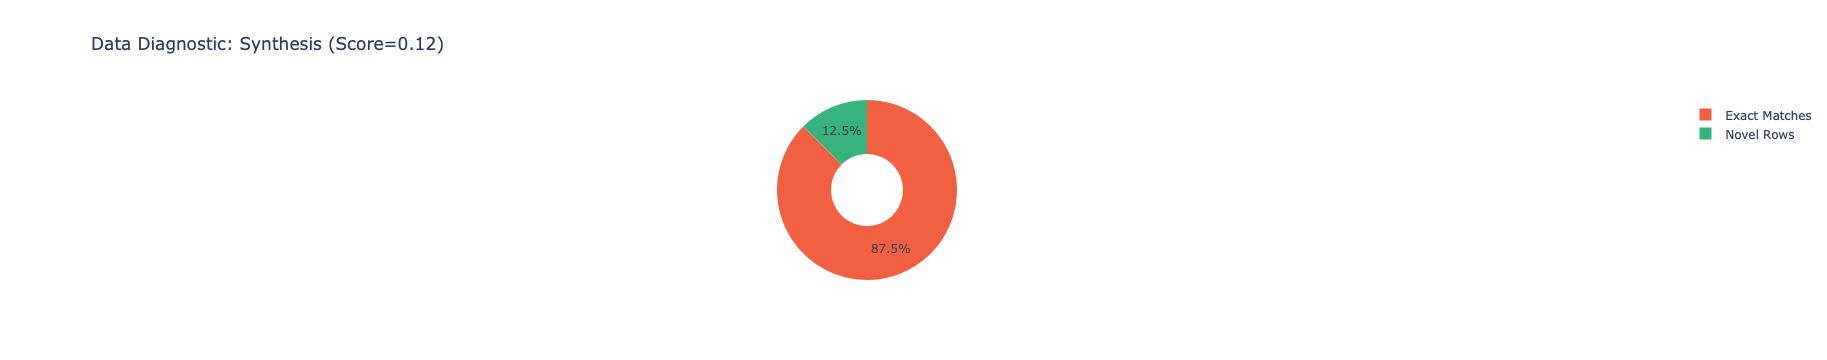

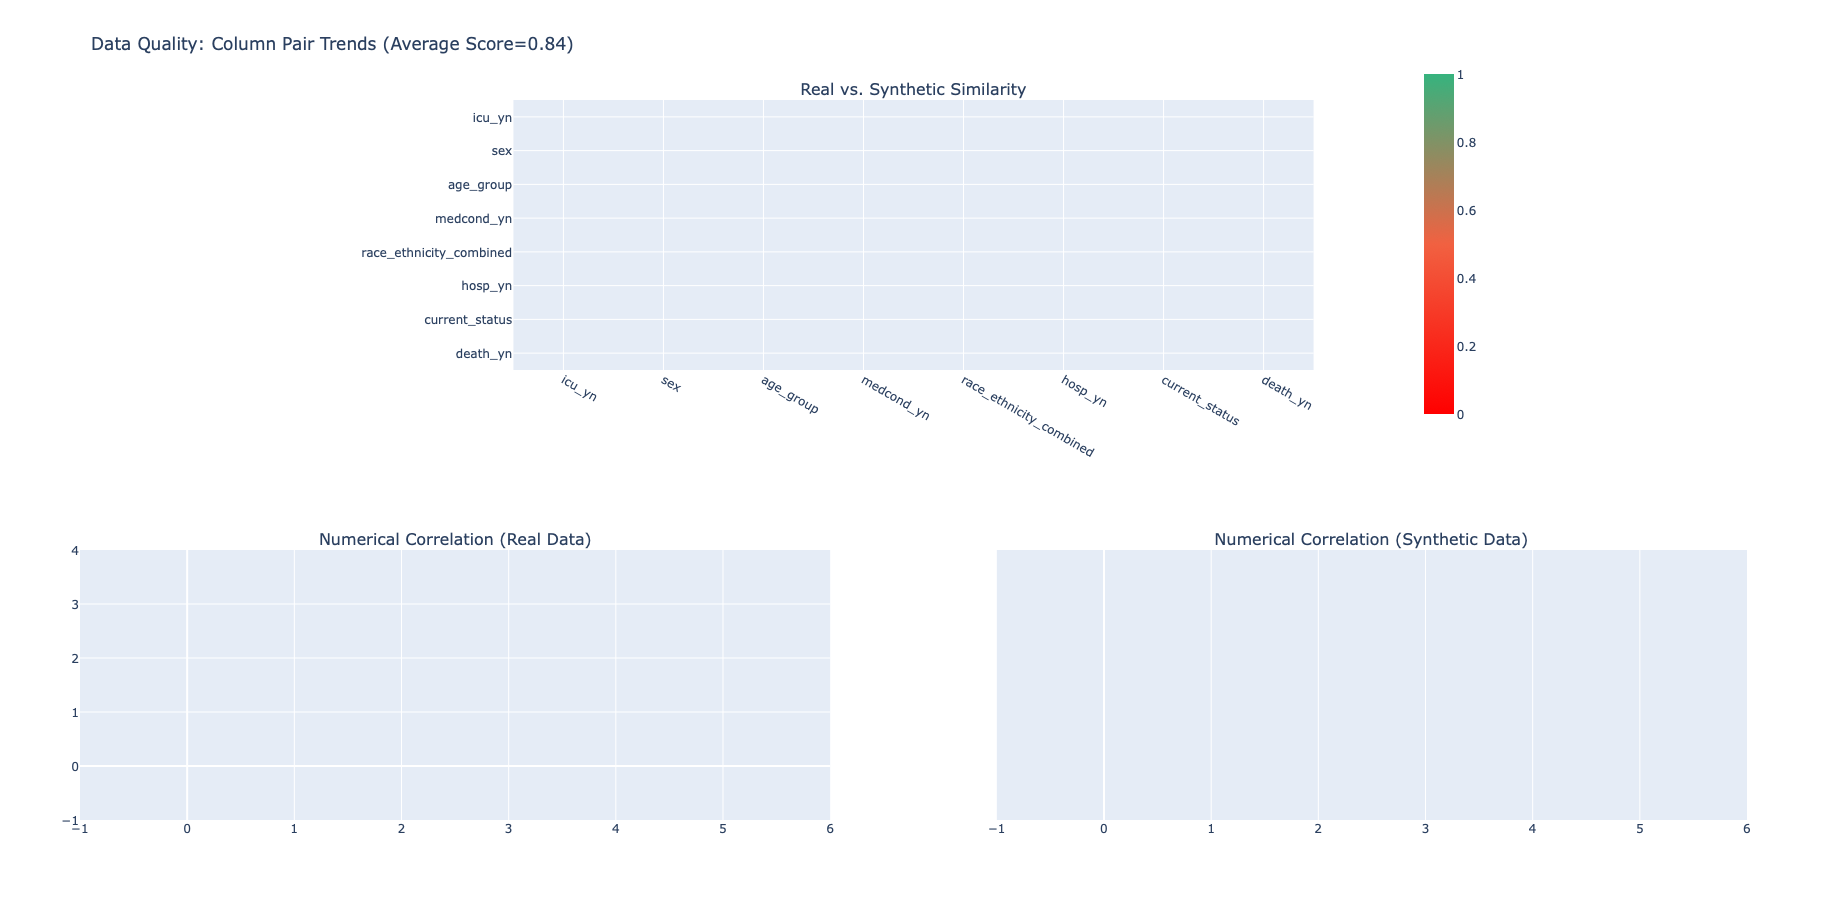

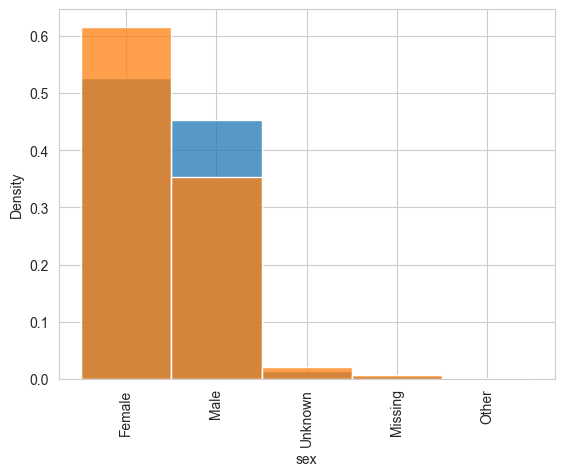

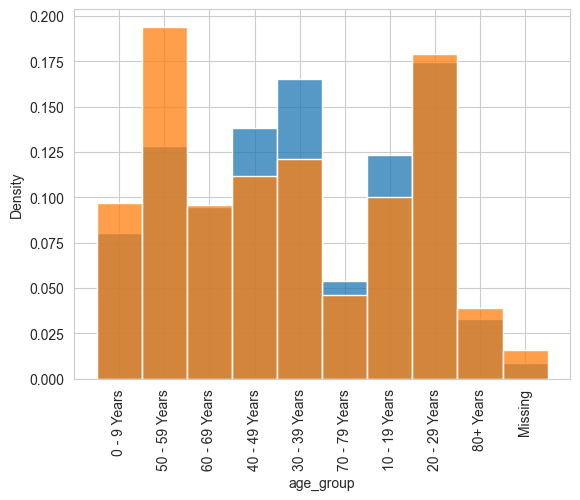

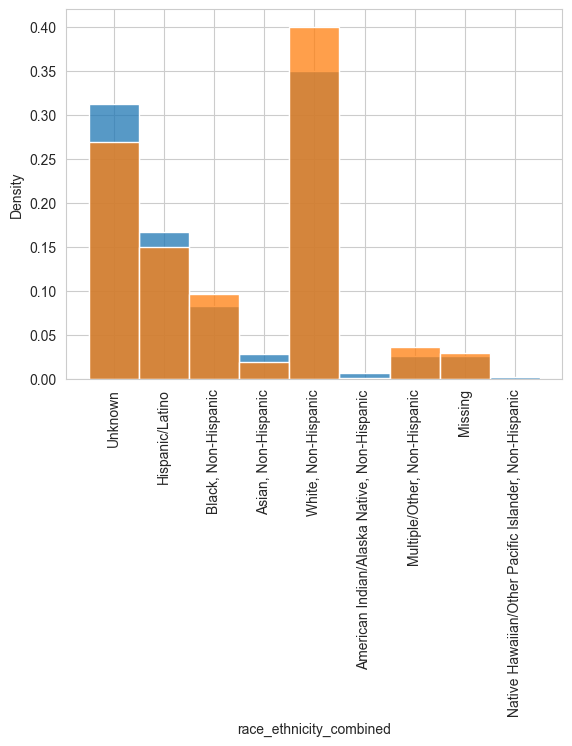

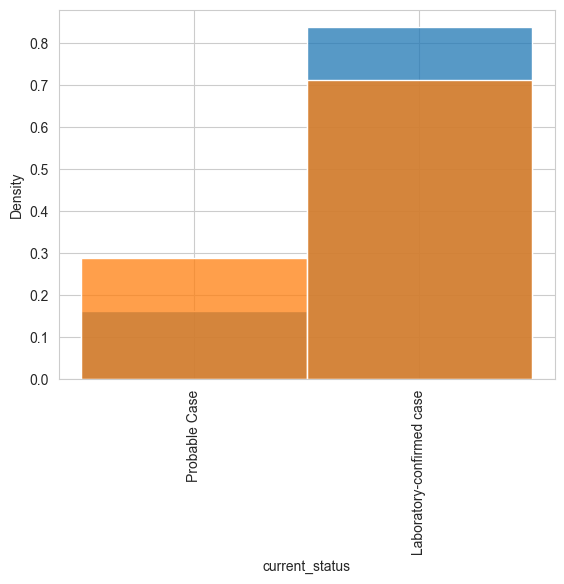

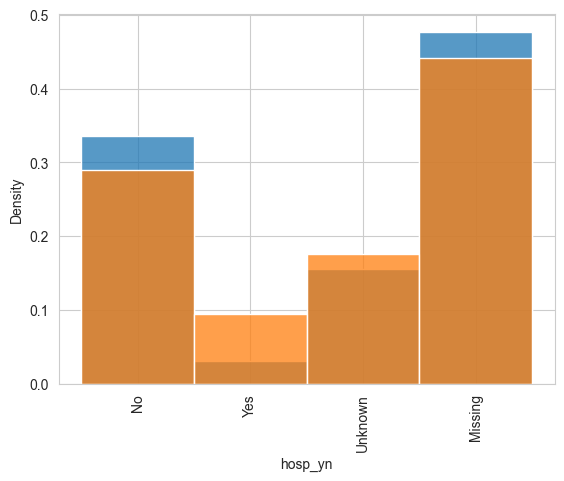

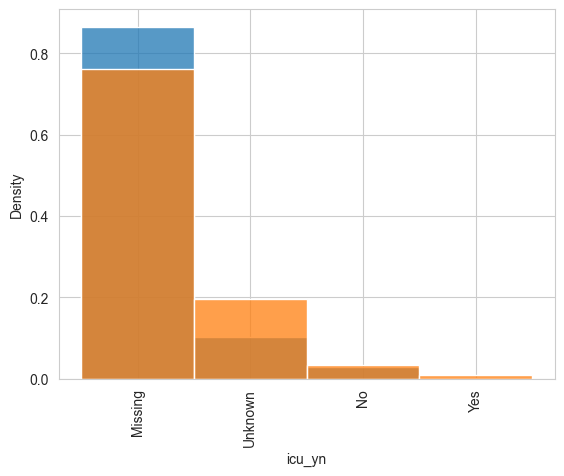

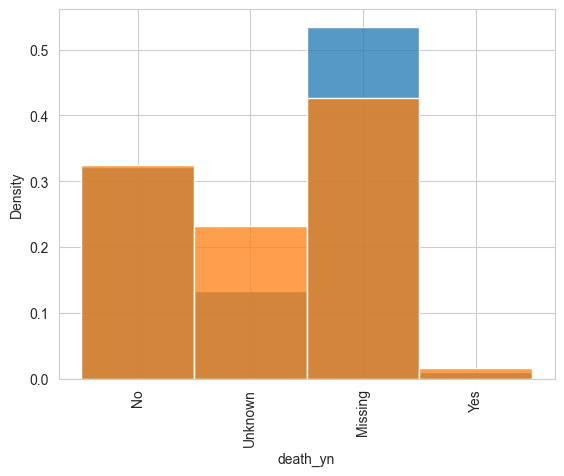

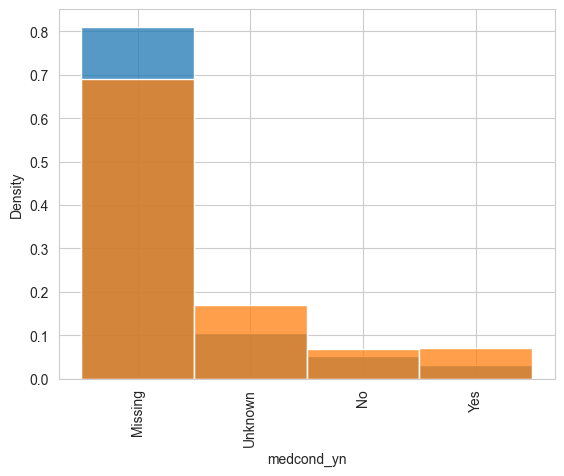

In [17]:
# Standard diagnostic report
report_diagnostic = DiagnosticReport()
report_diagnostic.generate(df, synth_data_ctgan, metadata_df)

# Standard quality report
report_quality = QualityReport()
report_quality.generate(df, synth_data_ctgan, metadata_df)

# Synthesis
# How many synthetic rows are exact matches with the real data?
fig = report_diagnostic.get_visualization(property_name='Synthesis')
fig.show()

# Trends between pairs of columns
# If both columns are numerical, the similarity is based on a simple correlation
# If both columns are categorical, the similarity is based on a contingency table
# If there is a mixture, the numerical column is cut into histogram bins and then
#  a contingency table is created.

# The first visualization are all the column pairs between real and synthetic data
# The second visualization are the numerical columns within the real and synthetic
# data.
fig = report_quality.get_visualization(property_name='Column Pair Trends')
fig.show()

# Custom figures
for column in df.select_dtypes(include=["object"]).columns:
    g = sns.histplot(df[column], stat="density")
    g = sns.histplot(synth_data_ctgan[column], stat="density")
    plt.xticks(rotation=90)
    plt.show()